# Variational AutoEncoders

Name: Azmi Haider  
ID: --------

### Import libraries

In [1]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-1-08983a184527>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

### Download Mnist dataset:

In [2]:
# Transformations applied on each image
def cont(sample):
    return ((sample * 255).to(torch.float) + torch.rand(sample.size())) / 256

# add uniform noise in the range of [0; 1], and then scale them from [0; 256] to [0; 1].
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor and scale to [0, 1]
    cont,# Add uniform noise in the range [0, 1)
])


# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 18349881.23it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 524483.22it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4364200.25it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10176564.51it/s]
INFO:lightning_fabric.utilities.seed:Seed set to 42


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
img, label = train_set[0]
print(f"image shape = {img.shape}")
print(f"values [{img.min()}, {img.max()}]")


image shape = torch.Size([1, 28, 28])
values [1.7964281141757965e-05, 0.9977026581764221]


A good practice is to always visualize some data examples to get an intuition of the data:

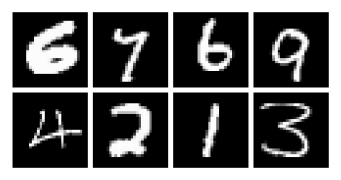

In [4]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

# VAE - Variational Auto-Encoder


**Encoder**  
The model begins with an encoder network composed of convolutional layers followed by batch normalization and ReLU activations. This part of the network transforms the input images (which are grayscale images of size 28x28) into a lower-dimensional representation (latent space dim=2). The final output of the encoder consists of two vectors, mu and logvar, which represent the mean and log-variance of a Gaussian distribution in the latent space.

**Latent Space**  
From mu and logvar, the model samples a point z in the latent space using the reparameterization trick. This latent vector z is a compressed representation of the input image and is intended to capture essential features without redundancies.

**Decoder**  
The decoder takes the latent vector z and reconstructs the original image. It starts by mapping z back to a higher-dimensional representation using a fully connected layer, followed by reshaping operations and transposed convolutional layers. Batch normalization and ReLU activations help in reconstructing the details of the image. The output of the decoder is a reconstruction of the original input image, which ideally matches the input image.

**Loss Function**  
During training, the model optimizes two main objectives:

**Reconstruction Loss**: Measures the difference between the input image and its reconstruction by modeling the output as Gaussian reconstruction term.
**KL Divergence Loss**: Regulates the latent space by ensuring it closely follows a standard Gaussian distribution. This promotes disentangled and meaningful representations in z.
The overall loss function, known as the Evidence Lower Bound (ELBO), combines these two losses with a balancing factor (beta parameter) to guide the trade-off between reconstruction fidelity and latent space regularization.

**Training and Optimization**  
The model is trained using the Adam optimizer, which updates the model parameters to minimize the ELBO loss. PyTorch Lightning simplifies the training loop by handling optimizations, logging of losses (train_loss, recon_loss, KL_loss), and metrics automatically.

**Evaluation**  
During training, validation and testing phases evaluate the model's performance on separate datasets. The validation and test steps compute the ELBO loss to monitor how well the model generalizes to unseen data.

**Generation and Latent Space Exploration**  
Once trained, the VAE can generate new images by sampling from the learned latent space (sample function). It can also map input images to their corresponding points in the latent space (map_to_latent_space), enabling analysis and manipulation of image features in a structured manner.



### The KL divergence term



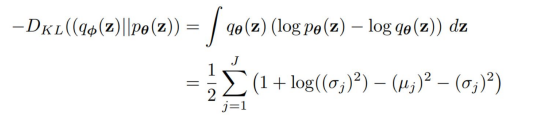

### The reconstruction loss

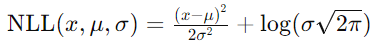

x - is the original input image  
𝜇 - is the reconstructed image x_recon  
σ - is the constant standard deviation, self.pixel_std = 0.1    
This NLL formulation is used as the reconstruction loss because it measures how likely the original input x is under the Gaussian distribution centered at the reconstructed output x_recon with standard deviation σ.



### The model

In [5]:

class VAE(pl.LightningModule):
    def __init__(self, z_dim=2):
        super().__init__()

        self.pixel_std = 0.1  # Fixed standard deviation for Gaussian distribution
        self.beta = 1 # weight for the KL loss vs The reconstruction loss

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, z_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, z_dim)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, output_padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

        # loggin
        self.elbo_train_t = []
        self.recon_train_t = []
        self.KL_train_t = []

        self.elbo_train, self.recon_train, self.KL_train = [], [], []

        self.elbo_val_t = []
        self.elbo_val = []

    def forward(self, x):
        # encoder
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        # sample latent
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu
        # decoder
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def calc_elbo(self, x, x_recon, mu, logvar):
        recon_x = x_recon.view(x_recon.size(0), -1)
        x = x.view(x.size(0), -1)

        d = x.size(1)
        B = x.size(0)

        # Mean squared error
        mse_loss = F.mse_loss(recon_x, x, reduction='sum') / B  # average over batch

        # Including the constant term in the reconstruction loss (not sure we need it)
        #constant_term = 0.5 * d * torch.log(torch.tensor(2 * torch.pi * self.pixel_std ** 2))
        #norm = 1 / (2 * self.pixel_std**2)
        reconstruction_loss = mse_loss #* norm + constant_term

        # KL divergence loss
        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / B  # average over batch
        KL = self.beta * KL

        ELBO = reconstruction_loss + KL

        # sum losses
        return ELBO, reconstruction_loss, KL

    def sample(self, num_samples):
        # N(0,1)
        z = torch.randn(num_samples, 2)
        # decode to generate images
        generated_images = self.decoder(z.to(self.device))
        generated_images = generated_images.view(num_samples, 1, 28, 28).cpu()
        return generated_images

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters())
        return optimizer

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_recon, mu, logvar = self(x)
        loss, recon_loss, KL_loss = self.calc_elbo(x, x_recon, mu, logvar)

        # Logging losses
        self.log('train_loss', loss, prog_bar=True)
        self.log('recon_loss', recon_loss, prog_bar=True)
        self.log('KL_loss', KL_loss, prog_bar=True)

        self.elbo_train.append(loss.detach().item())
        self.recon_train.append(recon_loss.detach().item())
        self.KL_train.append(KL_loss.detach().item())

        return loss

    def on_train_epoch_end(self):
        self.elbo_train_t.append(np.mean(self.elbo_train))
        self.recon_train_t.append(np.mean(self.recon_train))
        self.KL_train_t.append(np.mean(self.KL_train))

        self.elbo_train, self.recon_train, self.KL_train = [], [], []

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_recon, mu, logvar = self(x)
        loss, _, _ = self.calc_elbo(x, x_recon, mu, logvar)
        self.log('val_loss', loss, prog_bar=True)
        self.elbo_val.append(loss.detach().item())

    def on_validation_epoch_end(self):
        self.elbo_val_t.append(np.mean(self.elbo_val))
        self.elbo_val = []

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_recon, mu, logvar = self(x)
        loss, _, _ = self.calc_elbo(x, x_recon, mu, logvar)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def map_to_latent_space(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        # sample latent
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = eps * std + mu
        return z

### Training loop

To train the model, we again can rely on PyTorch Lightning and write a function below for loading the pretrained model if it exists. To reduce the computational cost, we have saved the validation and test score in the checkpoint already:

In [6]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "VAE"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=20,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor("epoch")])
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "VAE.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = VAE.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = VAE(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        result = trainer.test(model, test_loader, verbose=False)
    return model, result

### Training

In [7]:
model, result = train_model()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 56.1 K | train
1 | fc_mu     | Linear     | 6.3 K  | train
2 | fc_logvar | Linear     | 6.3 K  | train
3 | decoder   | Sequential | 65.3 K | train
-------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.536     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 36.50198745727539}]


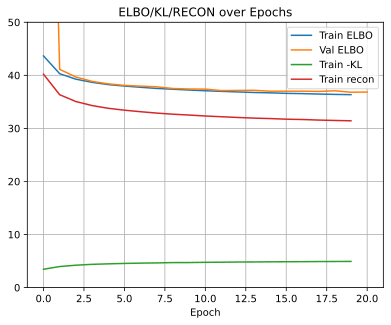

In [8]:
# report elbo for test
print(result)

# plot ELBO of training / val
plt.figure()
plt.plot(model.elbo_train_t, label='Train ELBO')
plt.plot(model.elbo_val_t, label='Val ELBO')
plt.plot(model.KL_train_t, label='Train -KL')
plt.plot(model.recon_train_t, label='Train recon')

plt.xlabel('Epoch')
plt.ylim(0, 50)

plt.legend()
plt.grid(True)
plt.title('ELBO/KL/RECON over Epochs')
plt.show()


## Sampling

Sampling from the latent space and demonstrating the reconstruction of those samples susing the decoder (done in the model's function "sample").

INFO:lightning_fabric.utilities.seed:Seed set to 1


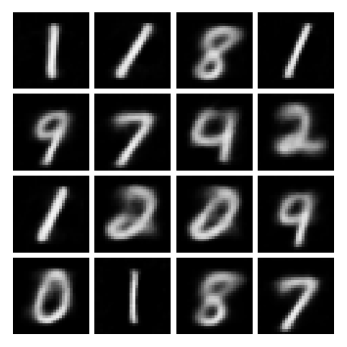

In [9]:
pl.seed_everything(1)
samples = model.sample(16)
show_imgs(samples.cpu())

# Section2: Traversals in the latent space

We demonstrate traversing the latent space of a Variational Autoencoder (VAE) to generate images that smoothly transition between two specified digits by traversing linearly between the latents of the images.
We show 3 pairs of traversals:

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


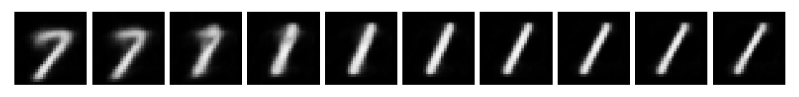

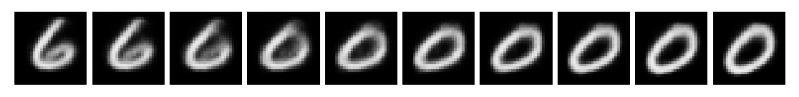

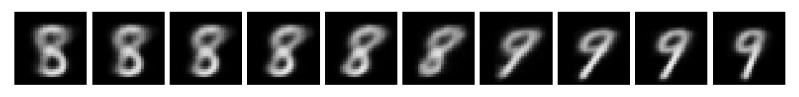

In [10]:
# traversals
# Define the number of rows and columns
num_rows = 3
num_travers = 10

imgs_all = []
digit_pairs = [(7, 1), (6, 0), (8, 9)]  # Example pairs of digits
images = {}
loader = data.DataLoader(train_set, batch_size=1, shuffle=True, drop_last=False, num_workers=1, persistent_workers=True)

for digit1, digit2 in digit_pairs:
  for _, (x, y) in enumerate(loader):
    label = y[0].item()
    if label == digit1:
      images[digit1] = x
    elif label == digit2:
      images[digit2] = x
    if digit1 in images and digit2 in images:
      break

for i, (digit1, digit2) in enumerate(digit_pairs):
  # Find two images from the dataset with the selected digits
  img1, img2 = images[digit1], images[digit2]
  # get latents for images
  with torch.no_grad():
    z1 = model.map_to_latent_space(img1.to(model.device))
    z2 = model.map_to_latent_space(img2.to(model.device))

    traversals = torch.linspace(0,1,num_travers)
    zs = [z2*t + (1-t)*z1 for t in traversals]
    zs = torch.cat(zs)

    # decode latents to images

    imgs = model.decoder(zs.to(model.device))
    imgs = imgs.view(num_travers, 1, 28, 28).cpu().detach()

    imgs = torchvision.utils.make_grid(imgs, nrow=num_travers, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5 * num_travers , 1.5))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')
plt.show()

## References

[1] https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

[2] https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

[3] https://www.tensorflow.org/tutorials/generative/cvae

